[Matthew Davis](https://www.virtustructure.com/), 2020

# George Floyd Library - Detect brutality in photos and videos through machine learning. 

With the recent riots going on in the world we thought how could we help use technology to solve these problems. Obviously the recent usage of video broadcast through the many platforms has seen an increase in videos about brutality by police officers. 

- [ ] Detect Poses
- [ ] Detect Depth over skeleton to understand how close people are
- [ ] Image Aquisition - Metadata pull and classification 
- [ ] Train brutality classifier 

In [0]:
# Uncomment when using on Google Colab:
!pip install --upgrade openpifpaf==0.11.2

Requirement already up-to-date: openpifpaf==0.11.2 in /usr/local/lib/python3.6/dist-packages (0.11.2)


In [0]:
%matplotlib inline

import io
import numpy as np
import openpifpaf
import PIL
import requests
import torch

# device = torch.device('cpu')
device = torch.device('cuda')  # if cuda is available

print(openpifpaf.__version__)
print(torch.__version__)

0.11.2
1.5.0+cu101


## Load an Example Image and Display It

Image credit: "[Learning to surf](https://www.flickr.com/photos/fotologic/6038911779/in/photostream/)" by fotologic which is licensed under [CC-BY-2.0].

[CC-BY-2.0]: https://creativecommons.org/licenses/by/2.0/

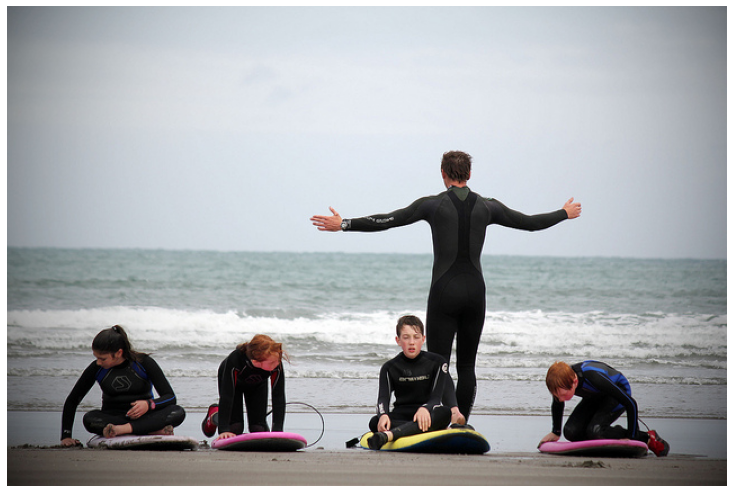

In [0]:
image_response = requests.get('https://raw.githubusercontent.com/vita-epfl/openpifpaf/master/docs/coco/000000081988.jpg')
pil_im = PIL.Image.open(io.BytesIO(image_response.content)).convert('RGB')
im = np.asarray(pil_im)

with openpifpaf.show.image_canvas(im) as ax:
  pass

## Load a Trained Neural Network

In [0]:
net_cpu, _ = openpifpaf.network.factory(checkpoint='shufflenetv2k16w')
net = net_cpu.to(device)

openpifpaf.decoder.CifSeeds.threshold = 0.5
openpifpaf.decoder.nms.Keypoints.keypoint_threshold = 0.2
openpifpaf.decoder.nms.Keypoints.instance_threshold = 0.2
processor = openpifpaf.decoder.factory_decode(net.head_nets, basenet_stride=net.base_net.stride)

Downloading: "http://github.com/vita-epfl/openpifpaf-torchhub/releases/download/v0.11.0/shufflenetv2k16w-200510-221334-cif-caf-caf25-o10s-604c5956.pkl" to /root/.cache/torch/checkpoints/shufflenetv2k16w-200510-221334-cif-caf-caf25-o10s-604c5956.pkl


## Dataset, Dataloader, Visualizer, Prediction

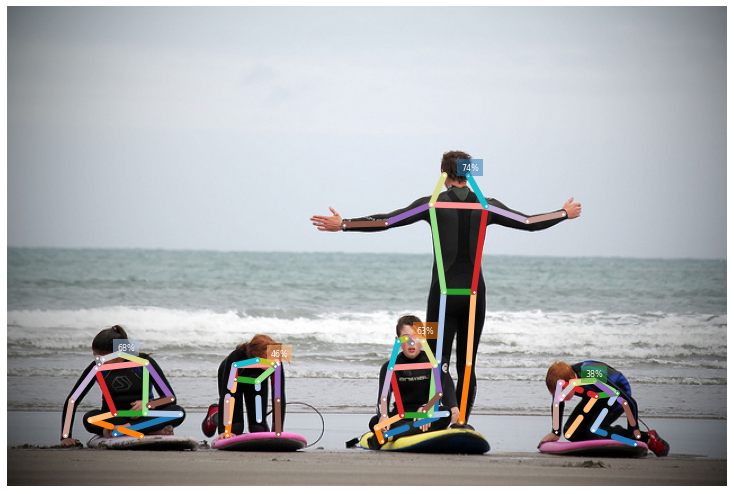

In [0]:
data = openpifpaf.datasets.PilImageList([pil_im])
loader = torch.utils.data.DataLoader(
  data, batch_size=1, pin_memory=True, 
  collate_fn=openpifpaf.datasets.collate_images_anns_meta)

keypoint_painter = openpifpaf.show.KeypointPainter(color_connections=True, linewidth=6)

for images_batch, _, __ in loader:
  predictions = processor.batch(net, images_batch, device=device)[0]
  with openpifpaf.show.image_canvas(im) as ax:
    keypoint_painter.annotations(ax, predictions)

In [0]:
#Now we have all people location 
#Retreive depth of those positions to see how close they are to each other 
#then feed that into a classifier model 
#Integrate this: https://github.com/ialhashim/DenseDepth to get the depth data 
#then download a large photo dataset and run that as metadata and label that data brutality/not


In [0]:
%tensorflow_version 1.x

In [0]:
!git clone https://github.com/ialhashim/DenseDepth.git

In [0]:
#load pretrained model 
!wget https://s3-eu-west-1.amazonaws.com/densedepth/nyu.h5 -O ./nyu.h5


In [0]:
def upload_files():
  from google.colab import files
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(k, 'wb').write(v)
  return list(uploaded.keys())

def preprocess_img(img_path):
  """
  The input image(s) is opened using PIL, the A-channel is removed (if it exists), 
  and the pixel values are normalized into the range 0-1.

  INPUT:
    a list of image path(s).

  OUTPUT:
    a numpy array of the stacked images.
  """
  loaded_images = []
  for file1 in img_path:
    img = Image.open(file1).resize((640, 480))
    img = np.asarray(img, dtype=float)[:, :, 0:3]
    x = np.clip(img / 255, 0, 1)
    loaded_images.append(x)
  inputs = np.stack(loaded_images, axis=0)
  return inputs

In [0]:
!cd "/content/DenseDepth/" && mv * "/content/"


In [0]:
# !cd "/content/DenseDepth"
import os
import glob
import argparse
import matplotlib
import numpy as np
from PIL import Image

# Keras / TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from keras.models import load_model
from layers import BilinearUpSampling2D
from utils import predict, load_images, display_images
from matplotlib import pyplot as plt

# # Argument Parser
# parser = argparse.ArgumentParser(description='High Quality Monocular Depth Estimation via Transfer Learning')
# parser.add_argument('--model', default='nyu.h5', type=str, help='Trained Keras model file.')
# parser.add_argument('--input', default='examples/*.png', type=str, help='Input filename or folder.')
# args = parser.parse_args()

# Custom object needed for inference and training
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}

print('Loading model...')

# Load model into GPU / CPU
model = load_model('nyu.h5', custom_objects=custom_objects, compile=False)

# print('\nModel loaded ({0}).'.format(args.model))

# Input images
# inputs = load_images( glob.glob(args.input) )

### My code START

# loaded_images = []
# for file1 in glob.glob("/content/*.png"): # upload the PNG images to the root dir
#   # the PNG images have an A-channel, so must remove it
#   # the model is only accepting images of size (640, 480), in accordance to the NYU dataset
#   # hence the images must be resized
#   img = Image.open(file1).resize((640, 480))
#   img = np.asarray(img, dtype=float)[:, :, 0:3]
#   x = np.clip(img / 255, 0, 1)
#   loaded_images.append(x)
# inputs = np.stack(loaded_images, axis=0)

### My code END

file_paths = upload_files()

inputs = preprocess_img(file_paths)

print('\nLoaded ({0}) images of size {1}.'.format(inputs.shape[0], inputs.shape[1:]))

# Compute results
outputs = predict(model, inputs)

#matplotlib problem on ubuntu terminal fix
#matplotlib.use('TkAgg')   

# Display results
viz = display_images(outputs.copy(), inputs.copy())
plt.figure(figsize=(20,10))
plt.imshow(viz)
plt.xticks([])
plt.yticks([])
plt.savefig('test.png')
plt.show()